# Importar librerias

In [87]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import multiprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from datetime import datetime as dt
import sys
import os
main_dir = os.path.abspath('..')
export_path = os.path.join(main_dir,'00_Utilities')
# adding Folder_2 to the system path
sys.path.insert(0, export_path)
from dirFunc import *

import warnings
warnings.filterwarnings('ignore')

# Importar datos

In [88]:
ruta_origen = 'Datos'

# De SAP
df = pd.read_csv(ruta_origen + '\\datosPreprocesados.csv')
# df.drop(columns=['genEstado','genTipoReparacion','genModelo'],inplace=True)

In [89]:
catCol = df.columns[(df.applymap(type) == str).all(0)].tolist()

# Utilidades

In [90]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Data Functions

In [91]:
# Variables Personalizadas
duracion_ix, MO_DyE_ix, MO_Reparar_ix, MO_End_ix = 15, 9, 10, 11
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        moPondDuracion = X[:, duracion_ix] / (X[:, MO_DyE_ix] + X[:, MO_Reparar_ix] + X[:, MO_End_ix])
        return self # np.c_[X, moPondDuracion]

In [92]:
def divisionEstratificada(df,compCol,componente,catCol):
    if componente:
        filterDf = df[df[compCol] == componente]
        train_set, test_set = train_test_split(filterDf, test_size=0.2,random_state=42)
        train_set.drop(columns=[compCol],inplace=True)
        test_set.drop(columns=[compCol],inplace=True)
        catCol.remove(compCol)
        return train_set, test_set, catCol

    else:
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        for train_index, test_index in split.split(df, df[compCol]):
            strat_train_set = df.loc[train_index]
            strat_test_set = df.loc[test_index]
        return strat_train_set, strat_test_set,catCol

In [93]:
def filterColumnsName(col,string, start, opposite=False):
    # Return a datatype called index from pandas
    filter = col.str.startswith(string) if start else col.str.endswith(string)

    return col[~filter] if opposite else col[filter]


In [94]:
def filterColumn(data,tipo): # tipo puede ser ['gen','mo','rep']
    col = data.columns
    varPredictivas = filterColumnsName(col,'YCostos',start=False)
    label = filterColumnsName(varPredictivas,tipo,start=True)
    varExplicativas = filterColumnsName(col,'YCostos',start=False,opposite=True)
    if tipo == 'mo':
        varExplicativas = filterColumnsName(varExplicativas,'rep',start=True,opposite=True)
    elif tipo == 'rep':
        varExplicativas = filterColumnsName(varExplicativas,'mo',start=True,opposite=True)
    dfX = data.copy()[varExplicativas.tolist()]
    dfY = data.copy()[label.tolist()]
    return dfX, dfY

## Model Functions

In [95]:
from sklearn.impute import SimpleImputer
def modelPipeline(df,vCat,vNum):
    # Normalizar y añadir variables numericas
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        # ('std_scaler', StandardScaler()),
    ])
    full_pipeline = ColumnTransformer([
    ("num", num_pipeline, vNum),
    ("cat", OneHotEncoder(), vCat),
    ])
    df_prepared = full_pipeline.fit_transform(df) 
    return df_prepared, full_pipeline


In [96]:
def gridSearchModel(df_prepared, df_labels, model):
    param_grid = [{'n_estimators': [20],#,25,30,35,40], 
                    # 'max_features': [2,3,4,5,6,7,8,9,10],
                    # 'max_samples': [0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.8],
                    # 'max_depth':[5],
                    # 'max_leaf_nodes': [5,6,7,8,9,10,11,13],
                    'min_samples_leaf':[5]}]
    grid_search = GridSearchCV(model, param_grid, cv=5,scoring='neg_mean_squared_error',
    return_train_score=True)
    grid_search.fit(df_prepared, df_labels)
    return grid_search

In [97]:
def rmseR2Calculator(modelo, x_test,y_test):
    final_predictions = modelo.predict(x_test)
    final_mse = mean_squared_error(y_test, final_predictions)
    final_rmse = np.sqrt(final_mse)

    r2 = r2_score(
        y_true  = y_test,
        y_pred  = final_predictions
       )
    final_mae = mean_absolute_error(y_true=y_test,y_pred=final_predictions)
    return {
        'rmse':final_rmse,
        'mae':final_mae,
        'r2':r2
    }

## Funciones de graficos

In [98]:
def getMainFeatures(modelo,vNum,componente):
    feature_importances = modelo.best_estimator_.feature_importances_
    # if componente:
    #     attributes = vNum
    # else:
    # if vCat:
    #     cat_encoder = pipeline.named_transformers_["cat"]
    #     cat_one_hot_attribs = list(np.concatenate(cat_encoder.categories_,axis=0))
    #     attributes = vNum + cat_one_hot_attribs 
    # else:
    attributes = vNum
    features = sorted(zip(feature_importances, attributes), reverse=True)
    return features

In [99]:
def plotFeatures(features,limit,filtroVar,componente):
  # plt.clf()
  plt.close()
  plt.clf()
  importance = []
  colNames = []

  for i in range(len(features)):
    importance.append(features[i][0])
    colNames.append(features[i][1])
  tipoVar = ['Repuestos' if i.startswith('rep') else 
            'Mano de Obra' if i.startswith('mo') else 
            'Generales' for i in colNames]
  df = pd.DataFrame({'Nombre de Columna': colNames,'Importancia': importance,'Clasificación': tipoVar})
  # f, ax = plt.subplots()
  ax = sns.barplot(data=df[:limit],x='Nombre de Columna', y='Importancia',
                  hue='Clasificación',dodge=False, palette=sns.color_palette("deep"))
  ax.set_xticklabels(colNames[:limit], rotation = 90)
  if componente:
        name = f'{filtroVar}{componente}RForest'
  else:
        name = f'{filtroVar}RForest'
  # plt.tight_layout()
  # plt.figure(figsize=(9, 11))
  ax.figure.savefig(f'img/barplots/{name}.png',bbox_inches='tight')

In [100]:
def treePlot(model, attributes,filtroVar,componente):
    plt.close()
    plt.clf()
    fig = plt.figure(figsize=(55, 10))
    plot_tree(model.best_estimator_.estimators_[1],feature_names = attributes,
            class_names= 'CostoTotal',filled = True,impurity = False,
            fontsize = 12,precision = 2,max_depth=4)
    if componente:
        name = f'{filtroVar}{componente}RForest'
    else:
        name = f'{filtroVar}RForest'
    plt.tight_layout()
    # fig = plt.figure(figsize=(9, 11))
    fig.savefig(f'img/trees/{name}.png',bbox_inches='tight')

# Modelo

In [101]:
def exeModelo(df,filtro,modelo,catCol,compCol,componente=None):
    # Dividir Data de entrenamiento y testeo
    dataTrain, dataTest, vCat= divisionEstratificada(df,compCol,componente,catCol)
    # Separar Variables explicativas y predictivas
    dfX,dfY = filterColumn(dataTrain,filtro)
    dfX_test,dfY_test = filterColumn(dataTest,filtro)

    # Variables Categoricas VS Numericas
    vNum = dfX.drop(columns=vCat).columns.tolist()
    
    df_prepared, full_pipeline = modelPipeline(dfX,vCat,vNum)
    df_prepared_test = full_pipeline.transform(dfX_test)

    # Grid Search Execution, calcula tiempo de ejecucion
    start = dt.now()
    gridModel = gridSearchModel(df_prepared,dfY,modelo)
    running_mins =round((dt.now()-start).seconds/60,2)
    features = getMainFeatures(gridModel,vNum,componente)

    # Creacion de graficos
    plotFeatures(features,10,filtro,componente)
    treePlot(gridModel, vNum,filtro,componente)

    # Calculo de errores
    error = rmseR2Calculator(gridModel,df_prepared_test,dfY_test)    

    # Documentacion de resultados
    # Texto de variables
    strVar = '\n'.join([f"{i+1}. {el}: {round(imp,3)}" for i,(imp,el) in enumerate(features)]).strip()

    # Texto de parametros usados
    strParams = "\n".join("{}:\t{}".format(k, v) for k, v in gridModel.best_params_.items()).strip()

    return len(features),strVar, error,strParams, len(dataTrain), running_mins

In [102]:
lst = []
# Establecer las posibles opciones del modelo
tipoComponente = [None] # ,'CO','DI','MA','MF','MO','TR']
nombreComponente = ['Todos'] # ,'Convertidor','Diferencial','Maza','Mando Final','Motor','Transmisor']
configVar = ['gen'] # ,'mo','rep'] # 
nombreConfig = ['Completo'] #,'Mano de Obra','Repuestos'] # 

Completo Todos


<Figure size 640x480 with 0 Axes>

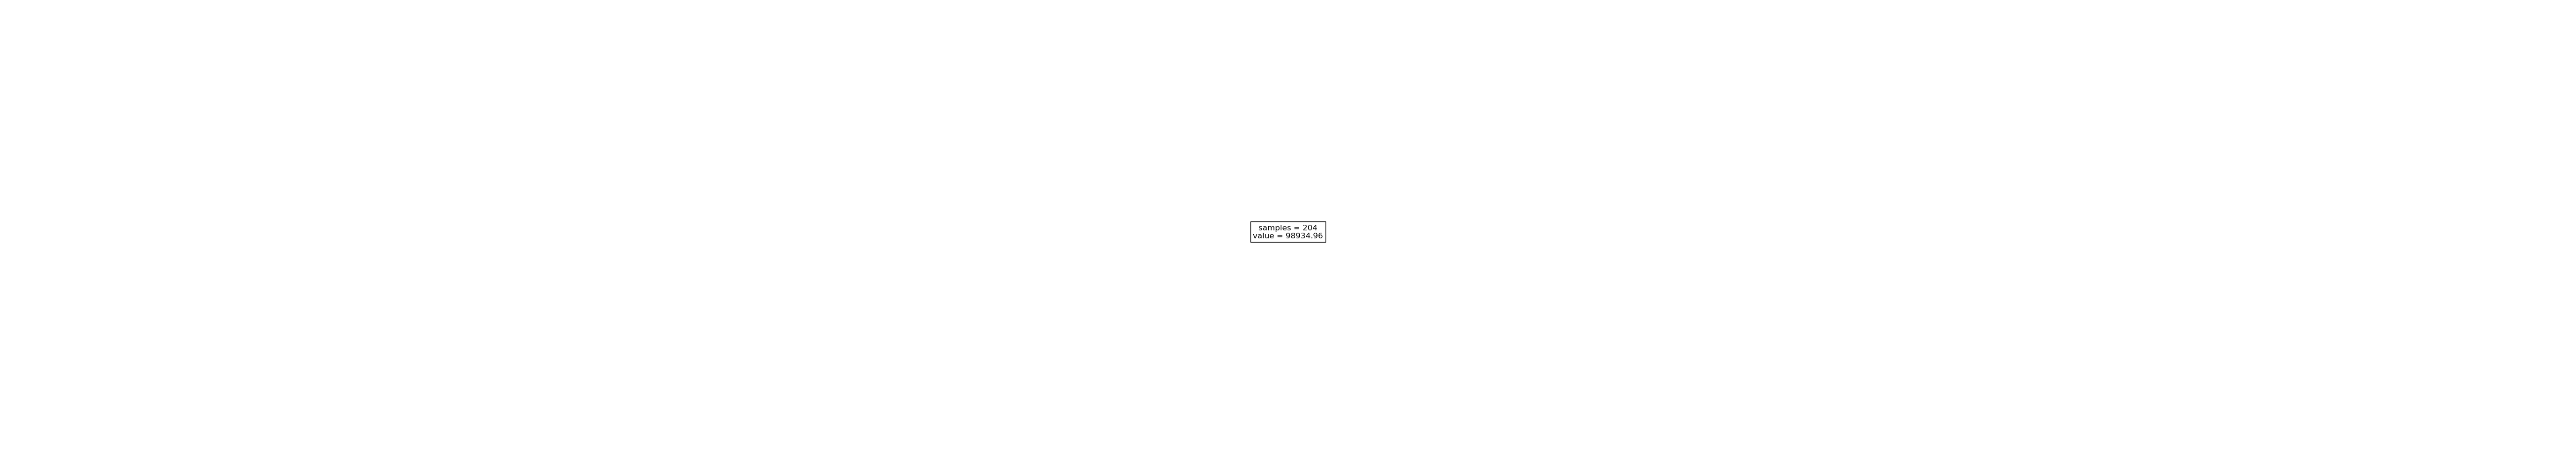

In [103]:
for nConf, conf in zip(nombreConfig,configVar):
    for nComp, componente in zip(nombreComponente,tipoComponente):
        print(nConf,nComp)
        # Try filtering Columns
        dfModel = df.copy()

        # Execute Modelo        
        totalVar,strVar,error,strParams,totalDatos,tiempo = exeModelo(dfModel,conf,RandomForestRegressor(),catCol,'genTipoComp',componente)
        
        # Documentar Resultados
        lst.append(['Random Forest', nConf, nComp,totalVar,strVar,totalDatos,error['rmse'],error['mae'],error['r2'],strParams,tiempo])

# Crea el data frame de resultados
cols = ['Modelo', 'Conjunto de Variables', 'Componente','Total de Variables','Importancia','Datos de Entrenamiento', 'RMSE','MAE','R2','Mejores Parametros','Tiempo de Ejecución']

results = pd.DataFrame(lst, columns=cols)

In [104]:
# for comp in nombreComponente:
#     focusVar = results[results.Componente==comp]
#     print(comp + '\n')
#     print('Parametros Usados')
#     print(focusVar['Mejores Parametros'].values[0])
#     print('')
#     print(f'Total Variables: {focusVar["Total de Variables"].values[0]}')
#     print('')
#     print(f'Datos: {focusVar["Datos de Entrenamiento"].values[0]}')
#     print('')
#     print(f'Error: {focusVar["RMSE"].values[0]}')
#     print('')

# Exportar Datos

In [105]:
ruta_destino = '05_Resultados'

# De SAP
exportar_csv(results,ruta_destino,'resultados')
exportar_excel(results,ruta_destino,'resultados')